1.Install  and import dependencies: OpenCV (for Andy); matplotlib for everyone

In [1]:
import cv2 # with opencv we can access our webcam, which can be helpful for our application or data capturing.
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Dependencies for model building- Tensorflow Functional API

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


Create Folder Structure: Set up the paths and make the folders

In [4]:
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data', 'anchor')

In [11]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

2.Collecting Data (Do not rerun)

In [ ]:
!tar -xf lfw.tgz

In [12]:
# Move all Images to data/anchor
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(ANC_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [16]:
# Share the pictures to the other folder, since I made a mistake in the previous step
for x in range(int(len(os.listdir(ANC_PATH))/2)):
     file = os.listdir(ANC_PATH)[x]
     EX_PATH = os.path.join(ANC_PATH,file)
     NEW_PATH = os.path.join(POS_PATH,file)
     os.replace(EX_PATH,NEW_PATH)

3.Load and Preprocess Images

Get Image Directories

In [28]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(1500)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(1500)
#negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(1500)


In [29]:
dir_test = anchor.as_numpy_iterator()

In [19]:
print(dir_test.next())

b'data\\anchor\\Amelie_Mauresmo_0016.jpg'


Preprocessing- Scale and Resize

In [30]:
def preprocess(file_path):
    #Read in image from file path
    byte_img = tf.io.read_file(file_path)
    #Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    #Resizing the image to be 105x105x3
    img = tf.image.resize(img,(105,105))
    #Normalization or scale image between 0 and 1 
    img = img/255.0

    return img 


In [31]:
img = preprocess('data\\anchor\\Amelie_Mauresmo_0016.jpg')

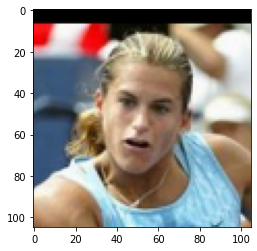

In [32]:
plt.imshow(img)

Create Labelled Dataset: Assign whether the both images are both faces or not

In [25]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
#negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
#data = positives.concatenate(negatives)



In [34]:
samples = positives.as_numpy_iterator()

In [36]:
example = samples.next()
example

(b'data\\anchor\\Tassos_Papadopoulos_0001.jpg',
 b'data\\anchor\\Jane_Clayson_0001.jpg',
 1.0)

Build Train and test sets

In [39]:
def data_preparing(input_img, validation_img, label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [40]:
res = data_preparing(*example)
# The * is for the unpacking of the tupple

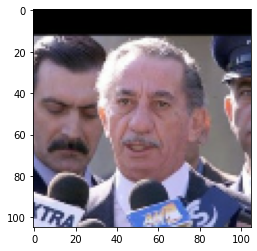

In [42]:
plt.imshow(res[0])
# Plot of the anchor image 

In [45]:
res[1]
# Real output: Array with numbers between 0 and 1 for each pixel.

<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
array([[[0.24622071, 0.19916189, 0.19916189],
        [0.23752835, 0.19887288, 0.1946712 ],
        [0.23108132, 0.2050309 , 0.19541372],
        ...,
        [0.26451913, 0.23314658, 0.22530344],
        [0.25882354, 0.22745098, 0.21960784],
        [0.25368813, 0.2223156 , 0.21447246]],

       [[0.2510671 , 0.20400828, 0.20400828],
        [0.24259703, 0.20394157, 0.19973989],
        [0.23579432, 0.2097439 , 0.20012672],
        ...,
        [0.26451913, 0.23314658, 0.22530344],
        [0.25882354, 0.22745098, 0.21960784],
        [0.25368813, 0.2223156 , 0.21447246]],

       [[0.256676  , 0.20961718, 0.20961718],
        [0.24677871, 0.20812325, 0.20392157],
        [0.24136321, 0.2153128 , 0.20569561],
        ...,
        [0.26451913, 0.23314658, 0.22530344],
        [0.25882354, 0.22745098, 0.21960784],
        [0.25368813, 0.2223156 , 0.21447246]],

       ...,

       [[0.64119875, 0.6372772 , 0.6608066 ],
        [0.66

In [44]:
res[2]
# Since both are faces, I've assigned them as true or 1. Later, when the negative set is completed, we'll have another value 0 for false.

1.0

In [46]:
# Build dataloader pipeline
positives = positives.map(data_preparing)
positives = positives.cache()
